<a href="https://colab.research.google.com/github/riguwen/MULforIC/blob/main/MUL_GLOBECOM_Shared_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Unlearning for Uplink Interference Cancellation

1.   List item
2.   List item





In this code tutorial we will guide an implementation of Machine Unlearning to forget an interfered (corrupted) model with inter-user interference. For this notebook, we have derived benefits from the NeurIPS 2023 Machine Unlearning Challenge.

Along with this tutorial, you should be able to import a corrupted data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for SNR classification.

## Authors: Eray Guven, Gunes Karabulut Kurt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/SimpleImgClas

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/SimpleImgClas


In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, model_selection
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

In [ ]:
print(torch.__version__)

2.2.1+cu121


## Import The Data
The first step before training the model is to import the data. We will use the [SIIC dataset](http://eraylink/) which is the custom dataset we generated explained in [1].

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` but you can change it to `64` if you like.

In [ ]:
%%capture
BATCH_SIZE = 32
## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])


**INPUT:** Loading the training data and labels as Matlab format. This is the input data which is the most crtitical part.  

In [ ]:

# Import necessary libraries
import scipy.io

# Path to the .mat file in Google Drive
file_path = '/content/drive/MyDrive/SimpleImgClas/globe1.mat'

# Load .mat file
mat_data = scipy.io.loadmat(file_path)

# Convert .mat data to tensor
tensor_data = torch.tensor(mat_data['IQ_s_sample'], dtype=torch.float32)
tensor_label = torch.tensor(mat_data['esenar'], dtype=torch.float32)

tensor_label = tensor_label /5;

reshaped_tensor_data_tr = tensor_data.view(3125, 32, 1, 28, 28)
reshaped_tensor_label_tr = tensor_label.view(3125, 32)

# Print tensor shape
print("Tensor shape:", reshaped_tensor_data_tr.shape)
print("Tensor shape:", reshaped_tensor_label_tr.shape)

Tensor shape: torch.Size([3125, 32, 1, 28, 28])
Tensor shape: torch.Size([3125, 32])


## Exploring the Data


Let's check what the train and test dataset contains. We will use `matplotlib` to print out some of the images from our dataset.

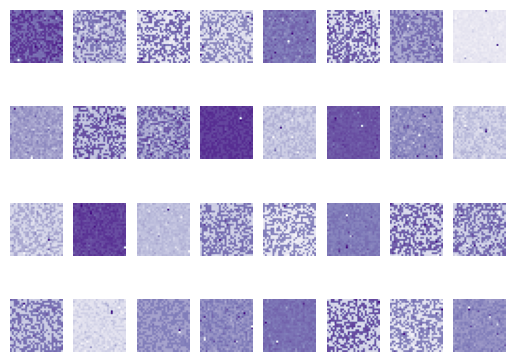

In [ ]:
def imshow_from_tensor(tensor_batch):
    # Convert the tensor batch to a numpy array
    npimg_batch = tensor_batch.numpy()

    # Plot each image in the batch
    for i in range(npimg_batch.shape[1]):  # Assuming the batch dimension is the first dimension
        plt.subplot(4, 8, i+1)  # Assuming 32 images, adjust if necessary
        plt.imshow(npimg_batch[0, i, 0], cmap='Purples')  # Assuming grayscale images, change cmap as needed
        plt.axis('off')
    plt.show()

# Example usage:
# Assuming reshaped_tensor_data_tr is your tensor
imshow_from_tensor(reshaped_tensor_data_tr[:, :32])


## An SNR Classifier Model
Now using the classical deep learning framework pipeline, which uses the 1 convolutional layer model.

Few notes regarding the network model
- The model described comprises an `__init__()` section where the layers and components of the neural network are defined. Within our model, we incorporate a convolutional layer represented by `nn.Conv2d(...)`.Since we're working with a grayscale image dataset, we only require one channel input, hence `in_channels=1`. To achieve a desirable representation from this layer, we set `out_channels=32`. The kernel size is specified as 3, while default values are utilized for the remaining parameters, which can be referenced [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).
- We employ two consecutive dense layers, also known as linear transformations, for processing the incoming data. Notably, for `d1`, the dimension may appear unexpected. The value 128 signifies the desired output size, while `26*26*32` corresponds to the dimension of the incoming data. For a detailed explanation on calculating these numbers, please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `5` is just the size of the output which also corresponds to the number of classes.
- In summary, the convolutional layer transforms the input data into a specific dimension, which must be taken into account in the subsequent linear layer. Similarly, in the second linear transformation (`d2`), the dimension of the output from the preceding linear layer is incorporated as `in_features=128`, and `5` represents the output size, which corresponds to the number of classes.

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 5)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

## Training the Model
Before proceeding with training the model, we will set up a loss function, an optimizer, and a function to compute the model's accuracy.

In [ ]:
learning_rate = 0.001 # Same learning rate for ML and MUL
num_epochs = 20 # Iteration for learning
epoch_unle = 20 # Iteration for unlearning

device = torch.device("cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
# UNCOMMENT HERE FOR TRAINING FROM SCRATCH. OTHERWISE, WE PRESENT A PRETRAINED MODEL (Q) IN THE BELOW

# for epoch in range(num_epochs):
#     train_running_loss = 0.0
#     train_acc = 0.0

#     model = model.train()
#     ## training step
#     #for i, (images, labels) in enumerate(trainloader):
#     for i, (images, labels) in enumerate(zip(reshaped_tensor_data_tr, reshaped_tensor_label_tr)):

#         images = images.to(device)
#         labels = labels.to(device)

#         ## forward + backprop + loss
#         logits = model(images)
#         images = images.type(torch.LongTensor)
#         labels = labels.type(torch.LongTensor)
#         loss = criterion(logits, labels)
#         optimizer.zero_grad()
#         loss.backward()

#         ## update model params
#         optimizer.step()

#         train_running_loss += loss.detach().item()
#         train_acc += get_accuracy(logits, labels, BATCH_SIZE)

#     model.eval()
#     print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
#           %(epoch, train_running_loss / i, train_acc/i))

In [ ]:
# LOADING THE PRETRAINED MODEL
#Load the model first

PATH = '/content/drive/MyDrive/SimpleImgClas/cnn_modelv29_tamtrain.pth'
# cnn_modelv233 = 180ktrain karisik zayif interenfrece
#  cnn_modelv29= test28 datasetinin train modeli

modela = MyModel()
modela.load_state_dict(torch.load(PATH))
modela = modela.to(device)



In [ ]:

# Load test data

#test29 : weak intereference -12 dB 1 user Case 1
#stronginterfere2 : t1 of strong intefrere -5 dB 1 user interferver Case 2
#stronginterfere :only strong intefrere -5 dB 1 user interferver Case 3
#train_nointerfer: nointerefer but 100k data enedst o be 20k cropped Case  4

file_path5 = '/content/drive/MyDrive/SimpleImgClas/train_nointerfer.mat'

# Load .mat file
mat_data5 = scipy.io.loadmat(file_path5)

# Convert .mat data to tensor
tensor_data_test2 = torch.tensor(mat_data5['IQ_s_sample'], dtype=torch.float32)
tensor_label_test2 = torch.tensor(mat_data5['esenar'], dtype=torch.float32)
tensor_label_test2 = tensor_label_test2 /5;

tensor_data_test2 = tensor_data_test2[:20000, :,:]  # Keep the first 50 rows, and keep all columns
tensor_label_test2 = tensor_label_test2[:20000, :]  # Keep the first 50 rows, and keep all columns


reshaped_tensor_data_test2 = tensor_data_test2.view(625, 32, 1, 28, 28)
reshaped_tensor_label_test2 = tensor_label_test2.view(625, 32)

# Print tensor shape
print("Tensor shape:", reshaped_tensor_data_test2.shape)
print("Tensor shape:", reshaped_tensor_label_test2.shape)

Tensor shape: torch.Size([625, 32, 1, 28, 28])
Tensor shape: torch.Size([625, 32])


In [ ]:
# EVALUATIOion of test and train data

def accuracy(net, loaderdata, loaderlabel):
    """Return accuracy on a dataset given by the data loader."""
    test_acc = 0
    for i, (images, labels) in enumerate(zip(loaderdata, loaderlabel)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    return test_acc/i

In [ ]:
# yaratilan modelde deneme yapiliyor. Normal test ve train set sonuclari
print('Train set accuracy: %.2f'%(accuracy(modela, reshaped_tensor_data_tr, reshaped_tensor_label_tr )))
print('Test set accuracy: %.2f'%(accuracy(modela, reshaped_tensor_data_test2, reshaped_tensor_label_test2)))

Train set accuracy: 40.52
Test set accuracy: 61.06


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def accuracy3(net, loaderdata, loaderlabel):
    """Return accuracy on a dataset given by the data loader."""
    test_acc = 0
    y_true = []
    y_pred = []
    for i, (images, labels) in enumerate(zip(loaderdata, loaderlabel)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    confusion = confusion_matrix(y_true, y_pred)
    return test_acc/i, confusion

accuracy_val, confusion_matrix_val = accuracy3(modela, reshaped_tensor_data_test2, reshaped_tensor_label_test2)
print('Train set accuracy: %.2f'%(accuracy_val))
print('Confusion Matrix:')
print(confusion_matrix_val)

Train set accuracy: 61.06
Confusion Matrix:
[[2720 1284    2    0    0]
 [  21  474 3507    0    0]
 [   3   12 3671  269    3]
 [   0    0  543 1516 2014]
 [   0    0   46  103 3812]]


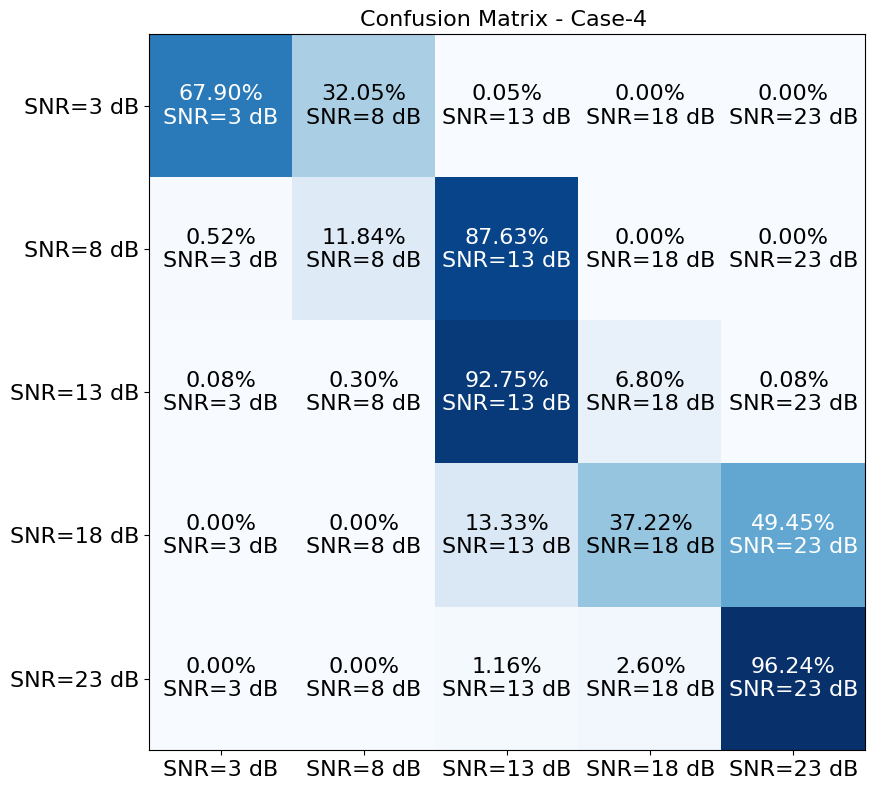

In [ ]:
# Display Confusion Matrix as Image
confusion_percent = confusion_matrix_val.astype('float') / confusion_matrix_val.sum(axis=1)[:, np.newaxis] * 100
class_labels = ["SNR=3 dB", "SNR=8 dB", "SNR=13 dB", "SNR=18 dB", "SNR=23 dB"]

# Display Confusion Matrix as Image with Percentage Values
plt.figure(figsize=(10, 8))

plt.imshow(confusion_matrix_val, interpolation='nearest', cmap=plt.cm.Blues)

# Add Percentage values and Class Labels as annotations
for i in range(confusion_matrix_val.shape[0]):
    for j in range(confusion_matrix_val.shape[1]):
        plt.text(j, i, "{:0.2f}%\n{}".format(confusion_percent[i, j], class_labels[j]),
                 horizontalalignment="center", verticalalignment="center",  fontsize=16,
                 color="white" if confusion_matrix_val[i, j] > confusion_matrix_val.max() / 2 else "black")

plt.title('Confusion Matrix - Case-4 ', fontsize=16)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=0, fontsize=16)
plt.yticks(np.arange(len(class_labels)), class_labels, fontsize=16)
plt.tight_layout()

plt.savefig('example_plot_Case-4.eps', format='eps')

plt.show()

In [ ]:
#UNLEARNING ALGORITHM
def unlearning(net, retain_t, retain_l, forget):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """


    for epoch in range(epoch_unle):
        train_running_loss = 0.0
        train_acc = 0.0

        model.train()
        ## training step
        #for i, (images, labels) in enumerate(trainloader):
        for i, (images, labels) in enumerate(zip(retain_t, retain_l)):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = net(images)
            images = images.type(torch.LongTensor)
            labels = labels.type(torch.LongTensor)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels, BATCH_SIZE)

        model.eval()
        message = 'Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
              %(epoch, train_running_loss / i, train_acc/i)
        print(message)
    return model, message

In [ ]:
#Datasets for Interference Unlearning Retain and Forget

import scipy.io
import os

file_path2 = '/content/drive/MyDrive/SimpleImgClas/forgetveretain.mat'
forgpath = '/content/drive/MyDrive/SimpleImgClas/forget_yed2.mat'

# Load .mat file
mat_data2 = scipy.io.loadmat(file_path2)
fordat = scipy.io.loadmat(forgpath)

# Convert .mat data to tensor
forget_train = torch.tensor(mat_data2['forget_train'], dtype=torch.float32)
forget_label = torch.tensor(mat_data2['forget_label'], dtype=torch.float32)

#nonzeroIndices = mat_data2['nonzeroIndices']
retain_train = torch.tensor(mat_data2['retain_train'], dtype=torch.float32)
retain_label = torch.tensor(mat_data2['retain_label'], dtype=torch.float32)
retain_label = retain_label /5

#retain_train = retain_train[:49920, :,:]  # Keep the first 50 rows, and keep all columns
#retain_label = retain_label[:49920, :]  # Keep the first 50 rows, and keep all columns




In [ ]:
retain_train =retain_train.view(3125, 32, 1, 28, 28)
retain_label = retain_label.view(3125, 32)

forget_train =forget_train.view(625, 32, 1, 28, 28)
forget_label = forget_label.view(625, 32)

forget_label = forget_label /5

# 🏅 Evaluation

In this segment, we aim to assess the effectiveness of the unlearning algorithm by employing a basic membership inference attack (MIA). We introduce this straightforward MIA as part of the cross-validation process for evaluating the unlearning algorithm's performance in uplink interference cancellation.

The membership inference attack (MIA) utilizes a logistic regression model, as detailed in the [logistic regression model documentation](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), to determine if a given sample was part of the training data based on its loss. To gauge the complexity of this task, we initially visualize a histogram below, illustrating the losses of the pre-trained model on both the training and testing sets in uplink dataset.

In [ ]:
#Load a pre-unlearndd model. Alternative to this, you can use the Unlearning Algorithm given above directly.
PATH444 = '/content/drive/MyDrive/SimpleImgClas/cnn_modelv_unlearned.pth' # YEni:" cnn_modelv_unlearned", eski :v unlearnedtr8
#Make a copy
ft_model = MyModel()
# Load weights
ft_model.load_state_dict(torch.load(PATH444))
ft_model = ft_model.to(device)


In [ ]:
# EVALUATIOion of test and train data

def accuracy4(net, loaderdata, loaderlabel):
    """Return accuracy on a dataset given by the data loader."""
    test_acc = 0
    for i, (images, labels) in enumerate(zip(loaderdata, loaderlabel)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    return test_acc/i

In [ ]:
print('Retain set accuracy: %.2f'%(accuracy(ft_model, retain_train, retain_label)))
print('Test set accuracy: %.2f'%(accuracy(ft_model, reshaped_tensor_data_test2, reshaped_tensor_label_test2)))
print('Forget set accuracy: %.2f'%(accuracy(ft_model, forget_train, forget_label)))
print('Traın set accuracy: %.2f'%(accuracy(ft_model, reshaped_tensor_data_tr, reshaped_tensor_label_tr)))


Retain set accuracy: 88.43
Test set accuracy: 91.83
Forget set accuracy: 29.24
Traın set accuracy: 52.78


In [ ]:
accuracy_val, confusion_matrix_val = accuracy3(ft_model, reshaped_tensor_data_test2, reshaped_tensor_label_test2)
print('Train set accuracy: %.2f'%(accuracy_val))
print('Confusion Matrix:')
print(confusion_matrix_val)

Train set accuracy: 91.83
Confusion Matrix:
[[4003    3    0    0    0]
 [  46 3936   20    0    0]
 [   6  144 3273  535    0]
 [   0   17  125 3309  622]
 [   0    2   20  124 3815]]


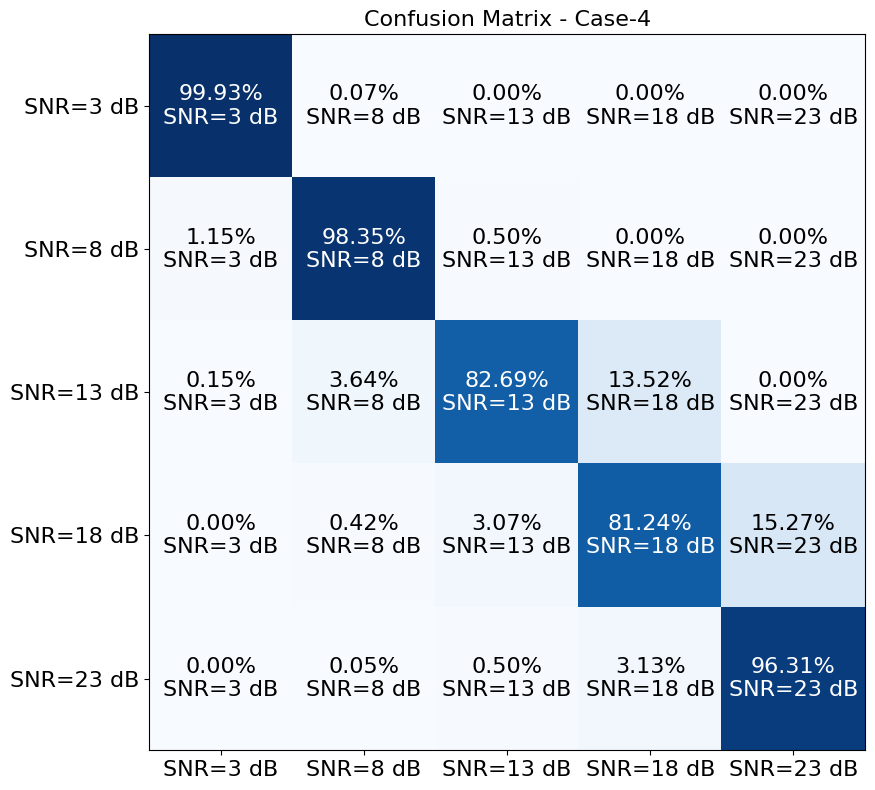

In [ ]:
# Display Confusion Matrix as Image
confusion_percent = confusion_matrix_val.astype('float') / confusion_matrix_val.sum(axis=1)[:, np.newaxis] * 100
class_labels = ["SNR=3 dB", "SNR=8 dB", "SNR=13 dB", "SNR=18 dB", "SNR=23 dB"]

# Display Confusion Matrix as Image with Percentage Values
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_val, interpolation='nearest', cmap=plt.cm.Blues)

# Add Percentage values and Class Labels as annotations
for i in range(confusion_matrix_val.shape[0]):
    for j in range(confusion_matrix_val.shape[1]):
        plt.text(j, i, "{:0.2f}%\n{}".format(confusion_percent[i, j], class_labels[j]),
                 horizontalalignment="center", verticalalignment="center",  fontsize=16,
                 color="white" if confusion_matrix_val[i, j] > confusion_matrix_val.max() / 2 else "black")

plt.title('Confusion Matrix - Case-4', fontsize=16)
#plt.colorbar()
#plt.xlabel('Predicted Label', fontsize=14)
#plt.ylabel('True Label', fontsize=14)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=0, fontsize=16)
plt.yticks(np.arange(len(class_labels)), class_labels, fontsize=16)
plt.tight_layout()

plt.savefig('example_plot2_Case-4.eps', format='eps')

plt.show()

In [ ]:
def compute_losses(net, loadertr, loadertes):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for i, (images, labels) in enumerate(zip(loadertr, loadertes)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        images = images.long()
        labels = labels.long()
        losses = criterion(outputs, labels).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

train_losses = compute_losses(modela, reshaped_tensor_data_tr, reshaped_tensor_label_tr)
test_losses = compute_losses(modela, reshaped_tensor_data_test2, reshaped_tensor_label_test2)

In [ ]:
def simple_mia(sample_loss, members, n_splits=6, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [ ]:
# MIA Calculation for test and forget samples
forget_losses = compute_losses(modela, forget_train, forget_label)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
#np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [ 0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.5f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.52125 on forgotten vs unseen images


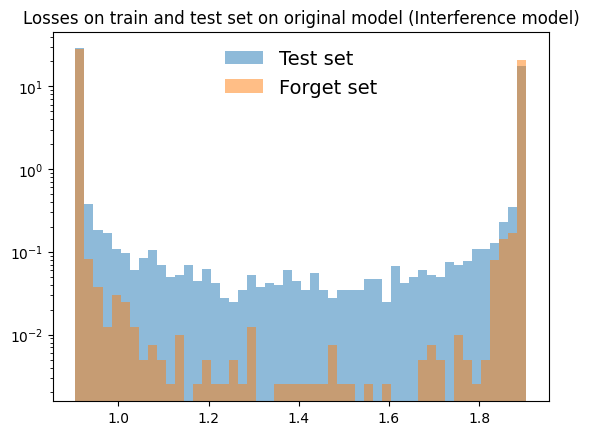

In [ ]:
# plot losses on train and test set on original model
plt.title("Losses on train and test set on original model (Interference model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
#plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")

plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
plt.show()

In [ ]:
ft_forget_losses = compute_losses(ft_model, forget_train, forget_label)
ft_test_losses = compute_losses(ft_model, reshaped_tensor_data_test2, reshaped_tensor_label_test2)
# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia2 = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia2)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.5f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.81304 on forgotten vs unseen images


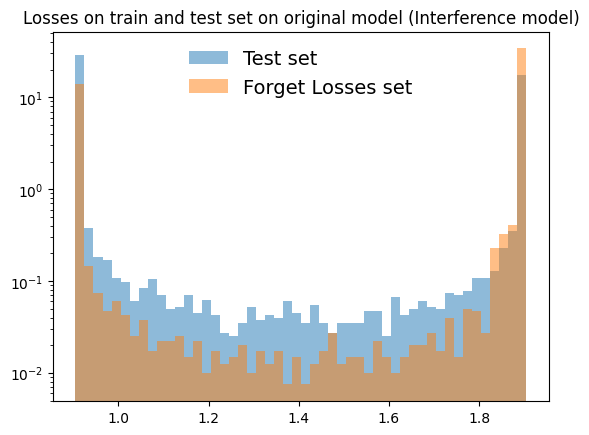

In [ ]:
# plot losses on train and test set on original model
plt.title("Losses on train and test set on original model (Interference model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget Losses set")
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
plt.show()


## Comparison with a re-trained retain (RR) model

One might inquire, how should we interpret the scores obtained from the membership inference attack (MIA)? What constitutes a good or bad score? Our objective is to approximate the performance of a model trained without interference on the dataset, which we consider the gold standard. Given that the signal-to-noise ratio (SNR) and signal-to-interference-plus-noise ratio (SINR) distributions are not identical, we anticipate that the MIA score will consistently exceed 0.5. However, various factors like distribution shift or class imbalance can cause this score to fluctuate. We will now proceed to compute this score. Firstly, we'll download the weights for a model trained exclusively on the retain set and subsequently calculate the accuracy of the simple MIA.

In [ ]:
# download weights of a model trained exclusively on the retain set
PATH2 = '/content/drive/MyDrive/SimpleImgClas/cnn_modelv_nointerfer.pth' #A Loading retained re-trained (RR) model

rt_model = MyModel()
rt_model.load_state_dict(torch.load(PATH2))
rt_model = rt_model.to(device)

print('Retain set accuracy: %.2f'%(accuracy(rt_model, retain_train, retain_label)))
print('Forget set accuracy: %.2f'%(accuracy(rt_model, forget_train, forget_label)))
print('Test set accuracy: %.2f'%(accuracy(rt_model, reshaped_tensor_data_test2, reshaped_tensor_label_test2))) #test loader


Retain set accuracy: 88.43
Forget set accuracy: 29.24
Test set accuracy: 91.83


**Comment:** As anticipated, the RR model exhibits notably high accuracy compared to the preceding ones, owing to the absence of interference during training.

In [ ]:
rt_test_losses = compute_losses(rt_model, reshaped_tensor_data_test2, reshaped_tensor_label_test2)
rt_forget_losses = compute_losses(rt_model, forget_train, forget_label)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.5f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.81304 on forgotten vs unseen images


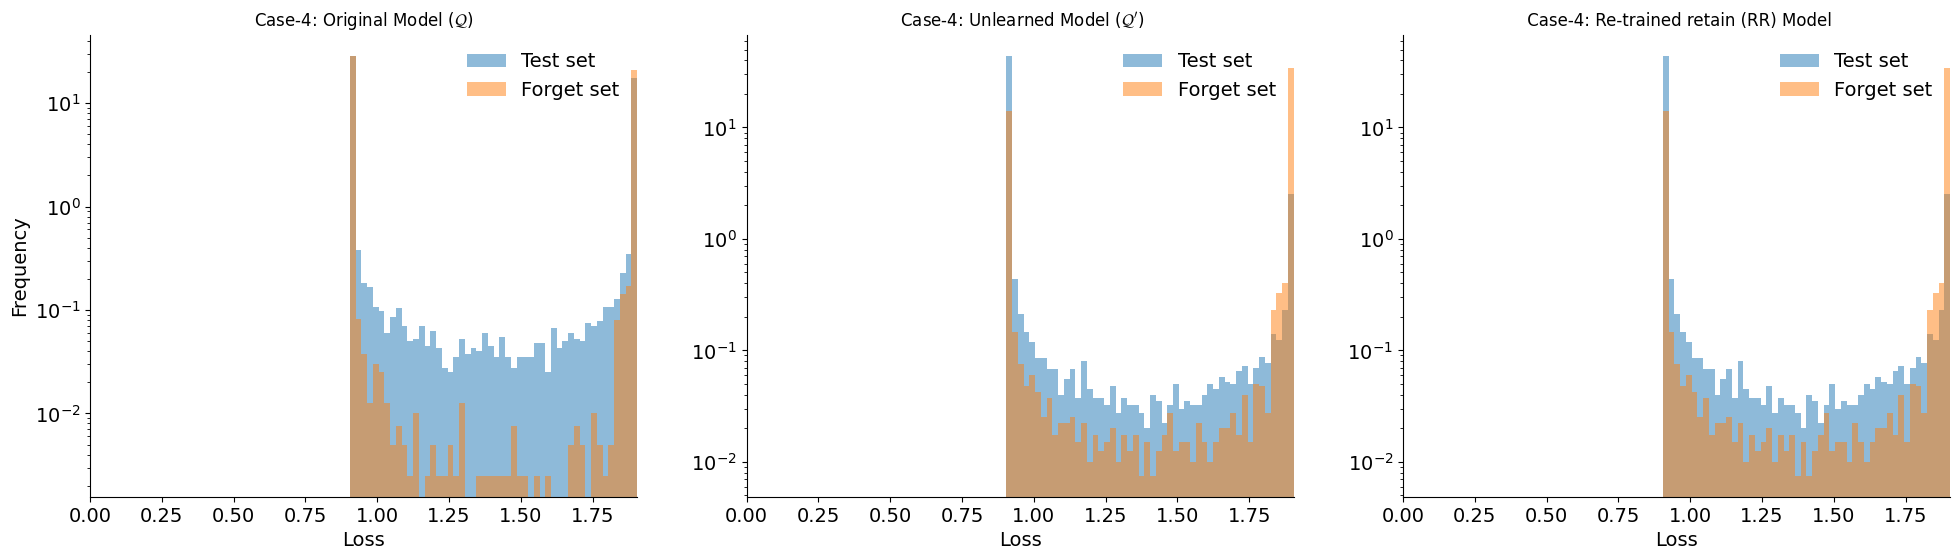

In [ ]:
# Figures for a single case.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.set_title(r"Case-4: Original Model ($\mathcal{Q}$)")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(r" Case-4: Unlearned Model ($\mathcal{Q}'$)")
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax3.set_title(r" Case-4: Re-trained retain (RR) Model")
ax3.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax3.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")


ax1.set_xlabel("Loss", fontsize=14)
ax2.set_xlabel("Loss", fontsize=14)
ax3.set_xlabel("Loss", fontsize=14)

ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale("log")

ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
ax3.set_xlim((0, np.max(test_losses)))

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)


for ax in (ax1, ax2, ax3):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
ax2.legend(frameon=False, fontsize=14)
ax3.legend(frameon=False, fontsize=14)

plt.savefig('MUL_Case-4.svg', format='svg')

plt.show()

**EXERCISE:** Cconsider integrating the testing phase into the code where you're displaying the training accuracy. This allows you to continually assess the model's performance on the testing data as you progress through the training steps. This approach proves valuable because you may prefer not to wait until the model has finished training to evaluate its performance on the testing data.

## Final Words
Here, we presented a SNR classification tutorial in Uplink Interference Cancellation with Machine Unlearning. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling. If you are interested in implementing a similar image classification model using RNNs see the references below.

## References
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
